In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from skimage import morphology
import os

In [2]:
root = "Z:/Projectline_modelling_lung_cancer/Nii_Processed/"
root = "//zkh/appdata/RTDicom/Projectline_modelling_lung_cancer/Users/Luis/CT_ITV_GTV_XBP_Nii/"

In [3]:
PxList = os.listdir(root)
len(PxList)

892

In [4]:
def LookFiles_Snapshot(folder_path):
    planCT_list,planCTLung_list = ([],[])
    bp50_list, bp50Lung_list = ([],[])
    gtvP_list, gtvN_list = ([],[])
    itvP_list, itvN_list = ([],[])
    for root,dirs,files in os.walk(folder_path):
        for f in files:
            if "PlanCT_CTProcessed.nii" in f:
                planCT_list.append(os.path.join(folder_path,f))
            if "PlanCT_LungProcessed.nii" in f:
                planCTLung_list.append(os.path.join(folder_path,f))
            if "bp50_CTProcessed.nii" in f:
                bp50_list.append(os.path.join(folder_path,f))
            if "bp50_LungProcessed.nii" in f:
                bp50Lung_list.append(os.path.join(folder_path,f))
            if "GTVn_GTProcessed.nii" in f:
                gtvN_list.append(os.path.join(folder_path,f))
            if "GTVp_GTProcessed.nii" in f:
                gtvP_list.append(os.path.join(folder_path,f))
            if "ITVn_GTProcessed.nii" in f:
                itvN_list.append(os.path.join(folder_path,f))
            if "ITVp_GTProcessed.nii" in f:
                itvP_list.append(os.path.join(folder_path,f))
    if len(bp50_list)==0: 
        for root,dirs,files in os.walk(folder_path):
            for f in files:
                if "bp60_CTProcessed.nii" in f:
                    bp50_list.append(os.path.join(folder_path,f))
                if "bp60_LungProcessed.nii" in f:
                    bp50Lung_list.append(os.path.join(folder_path,f))
    if len(bp50_list)==0: 
        for root,dirs,files in os.walk(folder_path):
            for f in files:
                if "bp40_CTProcessed.nii" in f:
                    bp50_list.append(os.path.join(folder_path,f))
                if "bp40_LungProcessed.nii" in f:
                    bp50Lung_list.append(os.path.join(folder_path,f))
    
    #print("Len of Files",len(planCT_list),len(planCTLung_list),len(bp50_list),len(bp50Lung_list),len(gtv_list),len(itv_list))


    return planCT_list,planCTLung_list,bp50_list,bp50Lung_list,itvP_list,itvN_list,gtvP_list, gtvN_list
    

In [ ]:
for Px in PxList:
    planCT_list,planCTLung_list,bp50_list,bp50Lung_list,gtv_list,itv_list = LookFiles_Snapshot(root+Px)

    ct_np  = nib.load(planCT_list[0]).get_fdata()
    lung_np  = nib.load(planCTLung_list[0]).get_fdata()

    bp50_np  = nib.load(bp50_list[0]).get_fdata()
    bp50Lung_np  = nib.load(bp50Lung_list[0]).get_fdata()

    itv_np  = nib.load(itv_list[0]).get_fdata()
    gtv_np  = nib.load(gtv_list[0]).get_fdata()
    
    
    ct_np.shape,lung_np.shape,itv_np.shape,gtv_np.shape,bp50_np.shape,bp50Lung_np.shape

    
    break
            
        


In [1]:
from LookFiles import *
from DataPreProc import *
from SinglePxRegist import *
import csv
from RegistwStats import *
from MergePandN_Fun import *
from NiiLoadAndOrientationFun import *
from FixResolutionFun import *
from DataPreProcTumor import *
from SaveFuns import *
import logging

c:\Users\delaoArevaLR\AppData\Local\anaconda3\envs\Ch2_July23_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
root = "//zkh/appdata/RTDicom/Projectline_modelling_lung_cancer/Users/Luis/CT_ITV_GTV_XBP_Nii/"
Px = "6959090/"

#aveImages = "5_4d_thorax_20__20__i30f__3__average_ct_PlanCT_CTProcessed.nii.gz"
aveImages = "110_ave-ip10_0_10_20_30_40_50_60_70_80_90.nii.gz"

#aveLungImg = "5_4d_thorax_20__20__i30f__3__average_ct_PlanCT_LungProcessed.nii.gz"
#aveLungImg = "4_4dthorax_rctp01_20__i30s__3__average_ct___imar___imar_PlanCT_LungProcessed.nii.gz"

itvp = "GTVp_created.nii.gz"
itvn = "GTVn_created.nii.gz"

In [17]:
currCTs = [os.path.join(root,Px,aveImages)]
itvTumor = [os.path.join(root,Px,itvp)]
itvNodes = [os.path.join(root,Px,itvn)]

In [18]:

ct_nii_ori = NiiLoadAndOrientation(currCTs[0])#orient to LAS
ct_np_ori = ct_nii_ori.get_fdata()
ctnpori_rot = np.rot90(ct_np_ori,axes=(0,1),k=-1)
ctResolution = FixResolution(ctnpori_rot,ct_nii_ori)

#Lung
#currCT_LungMask = CreateNOSaveLungMask(currCTs[0],SavePath=None)
#lungResolution = FixResolution(currCT_LungMask,ct_nii_ori)

#Tumor and Crop
itvTumorResolution,itvNodesResolution = DataPreprocTumor(itvTumor[0],itvNodes[0],ct_nii_ori)

Reoriented
Reoriented
Reoriented


In [19]:
itvTumorResolution.shape,itvNodesResolution.shape,ctResolution.shape

((650, 650, 400), (650, 650, 400), (650, 650, 400))

In [21]:
currCT_LungMask = CreateNOSaveLungMask(currCTs[0],SavePath=None)
lungResolution = FixResolution(currCT_LungMask,ct_nii_ori)

(160, 512, 512)


100%|██████████| 8/8.0 [00:07<00:00,  1.03it/s]

lungmask 2024-04-24 15:09:08 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


In [22]:
itvTumorFilled = FixHoles(itvTumorResolution)
itvNodesFilled = FixHoles(itvNodesResolution)
ctcropped,lungcropped,itvTumorcropped,itvNodesCropped = CropForegroundFunctionMONAI(ctResolution,lungResolution,itvTumorFilled,itvNodesFilled)

Pre (1, 650, 650, 400) Post Crop Shape (320, 320, 320)


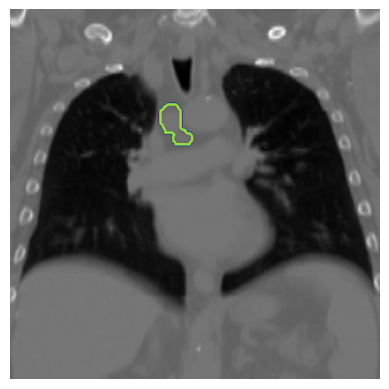

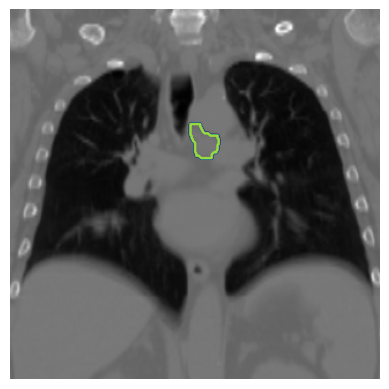

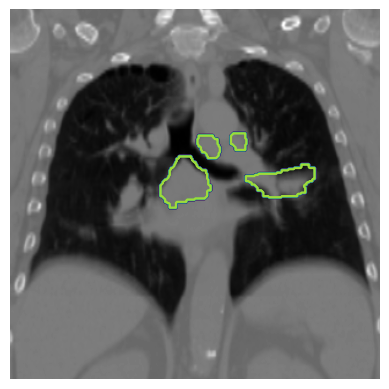

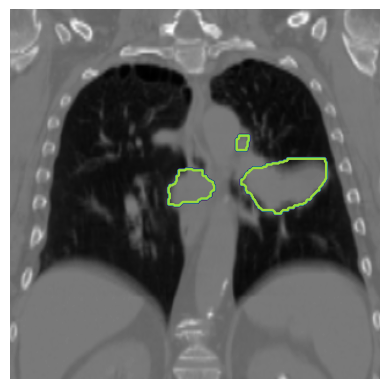

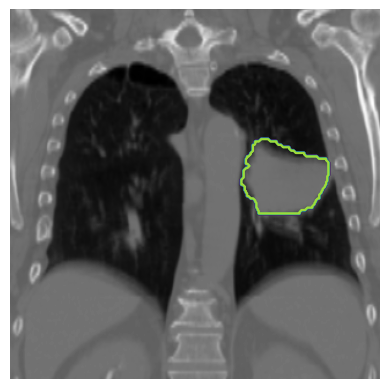

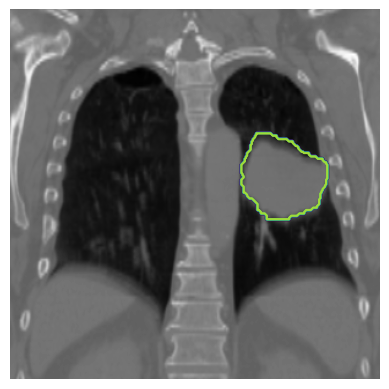

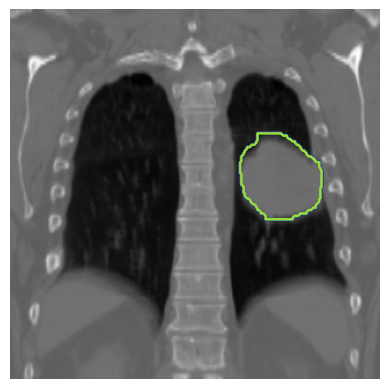

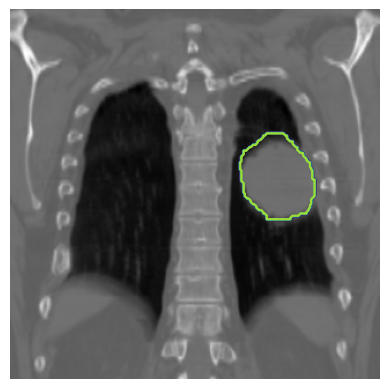

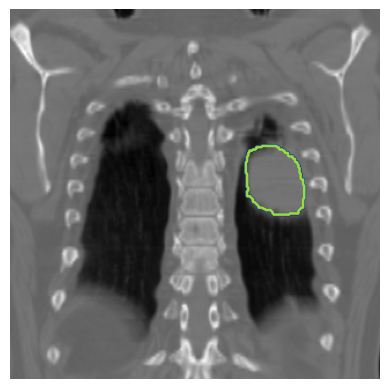

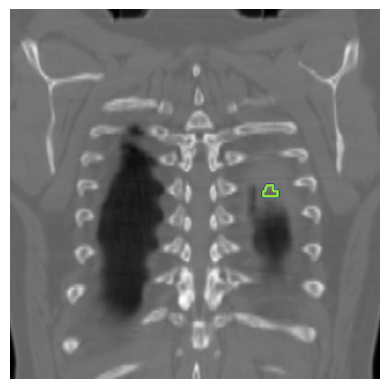

In [23]:
for i in range(0,itvTumorcropped.shape[-3],10):
    if np.sum(itvTumorcropped[i,:,:])>0:
        plt.imshow(np.rot90(ctcropped[i,:,:]),cmap="gray"),plt.axis("off")
        plt.contour(np.rot90(itvTumorcropped[i,:,:]))
        plt.contour(np.rot90(itvNodesCropped[i,:,:]))
        plt.show()